In [1]:
%reload_ext autoreload
%autoreload 2

# What jobs?

In [2]:
from Scratch import metadata_loader


DEVICE = "ibm_torino"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[:20]
print("shape:", md.shape)
md[:2]

state = Z0
shape: (20, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5483,2024-03-24 15:59:50.864000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zsqdvs8g008j7ra0,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:51:12.990431+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."
5482,2024-03-24 15:59:44.592000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zr7k5z700081s2tg,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:50:44.865382+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."


# Load the data

In [3]:
import json

SOFT_MUL = 0.5

# file_name = f'../results/{state}_{ROUNDS}.json'
file_name = f'../results/{DEVICE}_{state}_{ROUNDS}_soft_{SOFT_MUL}.json'


with open(file_name, 'r') as f:
    decoding_data = json.load(f)

print(len(decoding_data.keys()))

40


# Get the cummulative error dict

In [4]:
import numpy as np

distances = list(range(3, md["distance"].values[0] + 1, 4))
err_rate_dict = {d: [{}, 0] for d in distances}

for index, row in md.iterrows():
    decoding_results = decoding_data[row["job_id"]]
    shots = row["shots"] 
    for result in decoding_results:
        d_new = int(result["d_new"])
        decoding = result["decoding"]
        num_errors = np.sum(result["error_list"])
        num_subsets = len(result["error_list"])
        if decoding not in err_rate_dict[d_new][0]:
            err_rate_dict[d_new][0][decoding] = []
        err_rate_dict[d_new][0][decoding].append(num_errors)
        err_rate_dict[d_new][1] += shots * num_subsets/2 # bcs twice for hard and kde & times the nb of subsets


print(err_rate_dict)

mean_err_rate_dict = {}
for d in distances:
    mean_err_rate_dict[d] = {}
    for decoding in err_rate_dict[d][0]:
        mean_err_rate_dict[d][decoding] = np.sum(err_rate_dict[d][0][decoding]) 
    mean_err_rate_dict[d]["shots"] = err_rate_dict[d][1]

print(mean_err_rate_dict)


{3: [{'kde': [7190, 7124, 6897, 7077, 7019, 7032, 7100, 7363, 7060, 6746, 6827, 6649, 6860, 6762, 6884, 6857, 7011, 7100, 6889, 7075], 'hard': [8387, 8393, 8167, 8214, 8286, 8299, 8417, 8598, 8535, 7955, 8150, 7841, 8029, 8036, 8048, 8044, 8298, 8297, 8047, 8397]}, 782880.0], 7: [{'kde': [1487, 1509, 1408, 1418, 1394, 1419, 1474, 1461, 1473, 1299, 1333, 1301, 1318, 1300, 1404, 1339, 1431, 1448, 1427, 1469], 'hard': [2148, 2092, 1981, 2032, 1996, 2001, 2075, 2127, 2123, 1909, 1884, 1841, 1921, 1930, 1970, 1934, 1952, 1976, 2074, 2058]}, 279600.0], 11: [{'kde': [515, 491, 515, 459, 477, 513, 513, 520, 502, 429, 440, 448, 477, 477, 477, 458, 483, 470, 499, 469], 'hard': [853, 892, 830, 806, 805, 873, 844, 854, 844, 737, 774, 706, 769, 813, 827, 736, 790, 791, 856, 851]}, 167760.0], 15: [{'kde': [233, 224, 229, 202, 209, 233, 194, 267, 236, 170, 186, 197, 193, 209, 197, 194, 203, 224, 199, 234], 'hard': [416, 440, 421, 414, 381, 431, 427, 422, 421, 341, 332, 354, 394, 400, 389, 365, 379, 3

# Plot

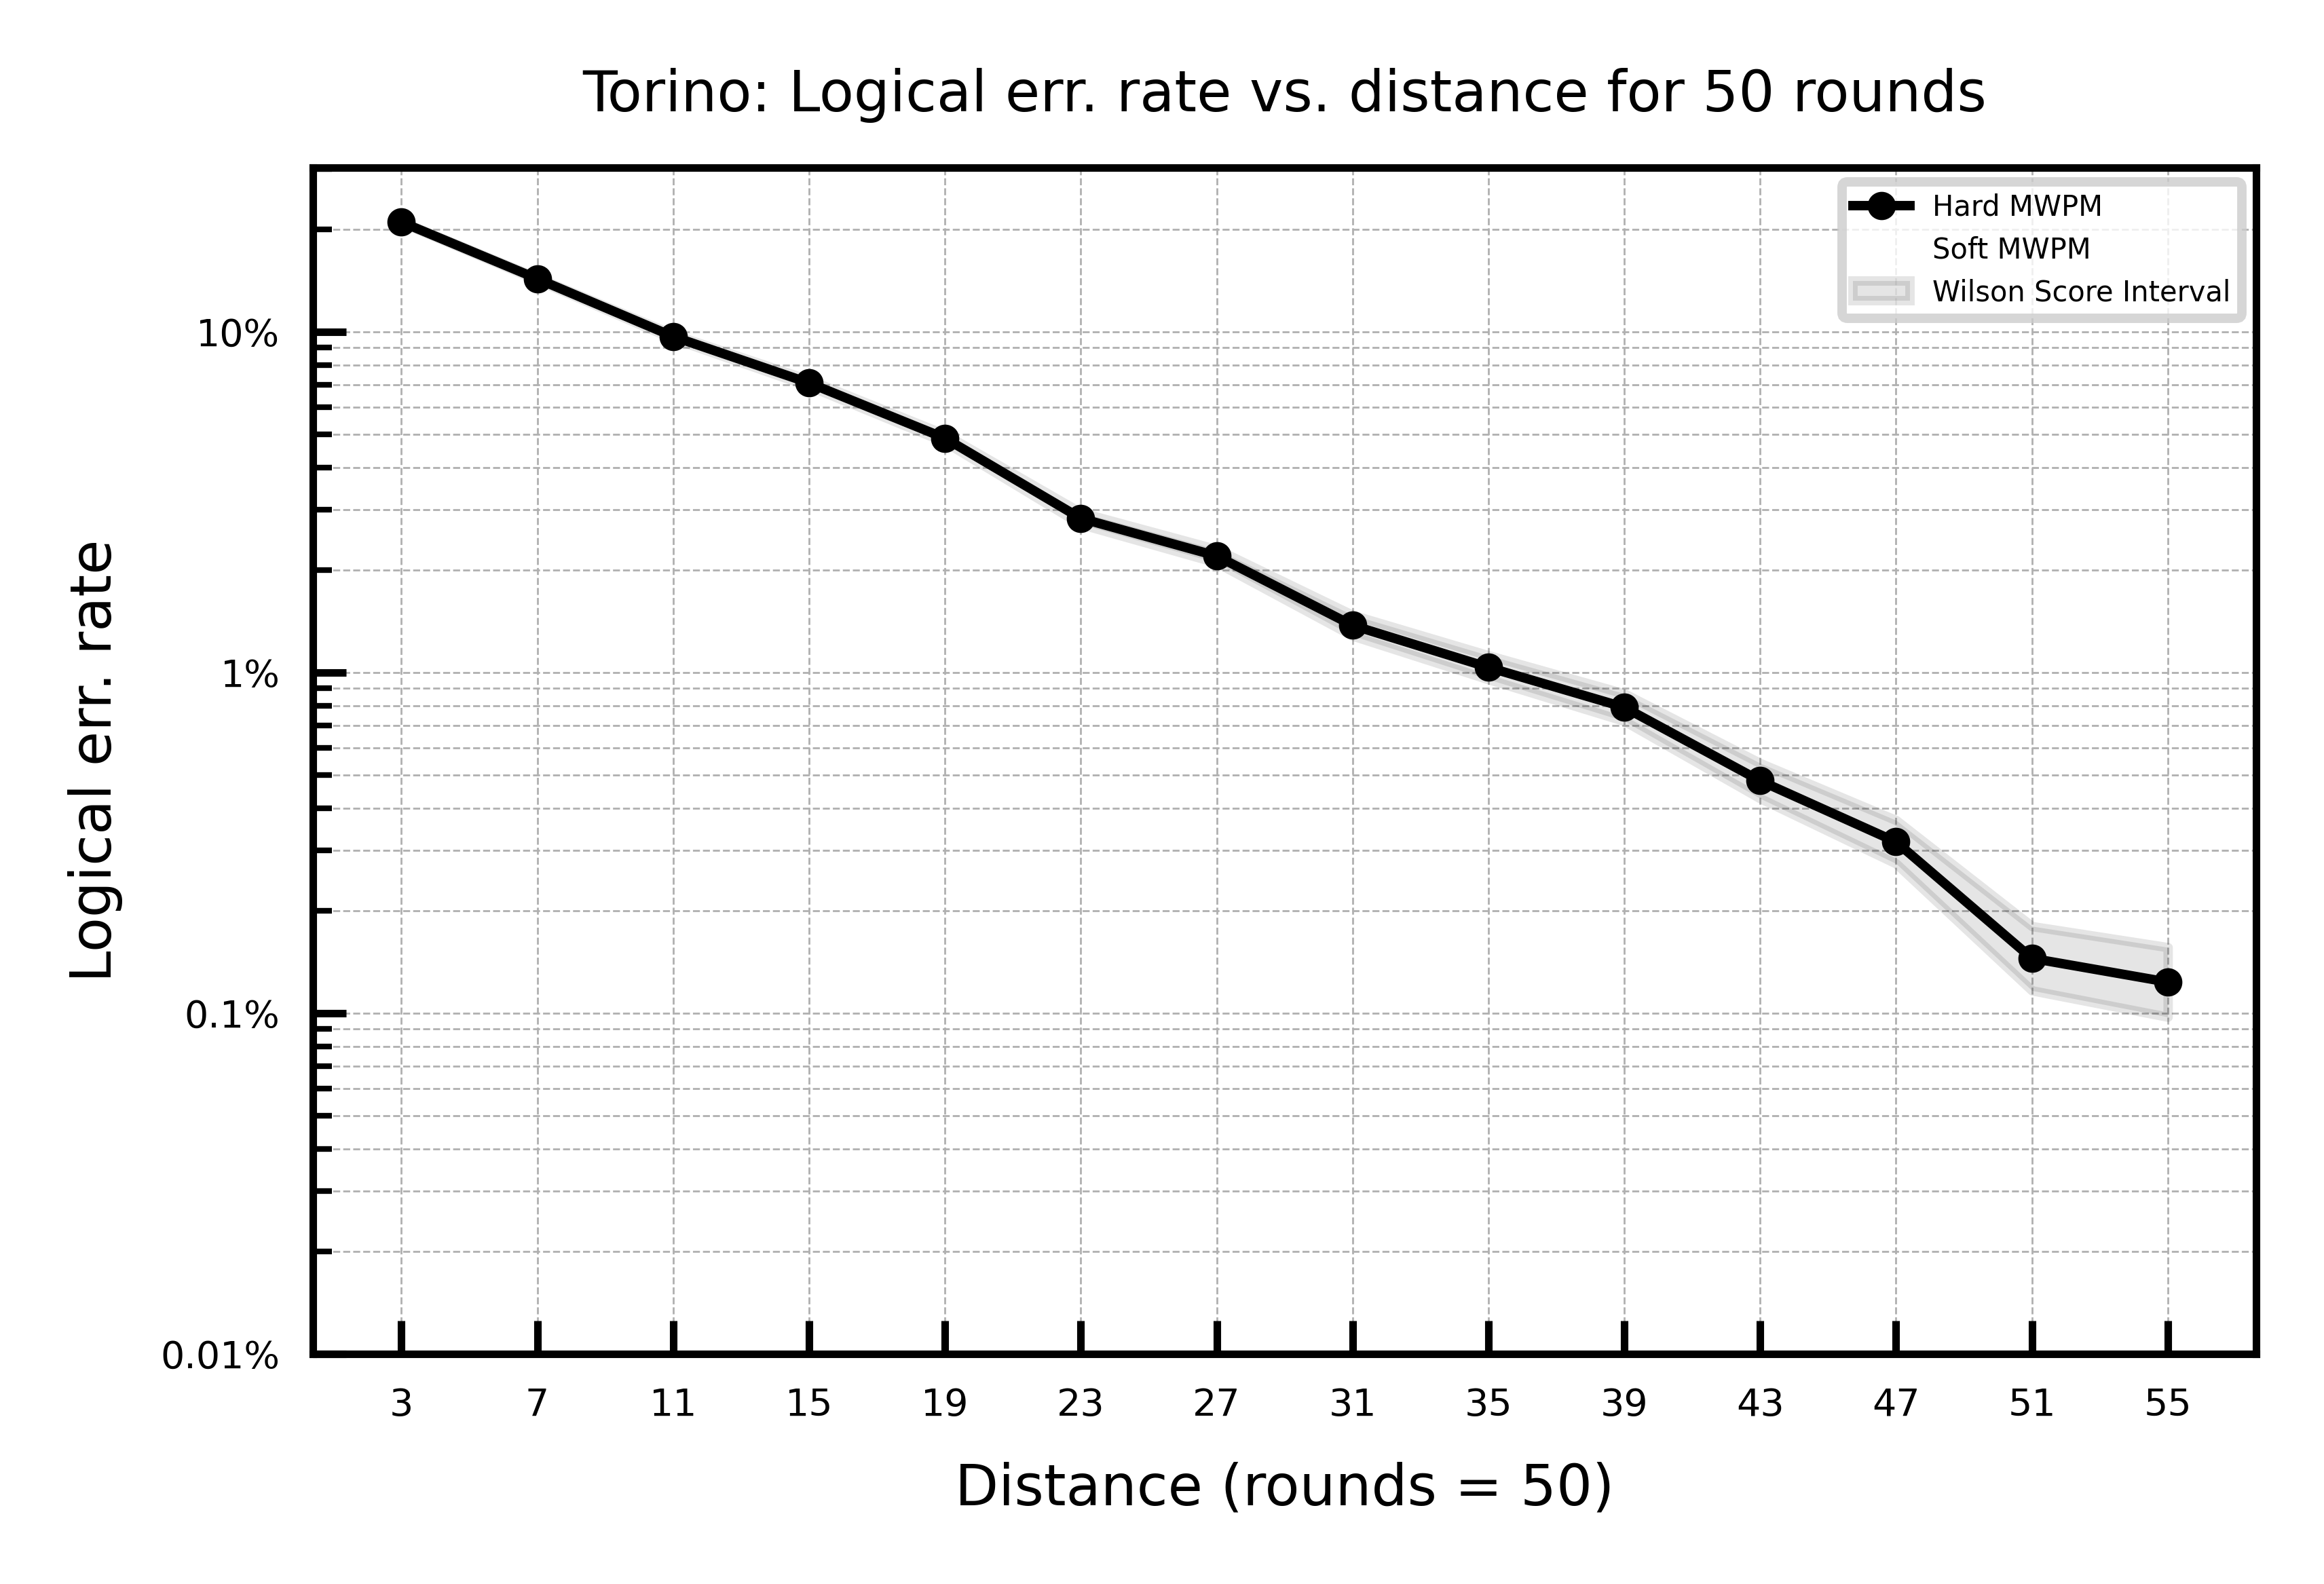

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Setup plot parameters for PRX style
FIGURE_WIDTH_1COL = 3.404
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL * 2 / (1 + np.sqrt(5)) * 1.1
font_size = 6

plt.rcParams.update({
    'font.size': font_size,
    'figure.titlesize': 'medium',
    'figure.dpi': 1000,
    'figure.figsize': (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize': 'medium',
    'axes.axisbelow': True,
    'xtick.direction': 'in',
    'xtick.labelsize': 'small',
    'ytick.direction': 'in',
    'ytick.labelsize': 'small',
    'image.interpolation': 'none',
    'legend.fontsize': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'font.family': 'sans-serif',
})

# Wilson score interval function for confidence intervals
def wilson_score_interval(p, n, z=1.96):
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)

# Assuming 'mean_err_rate_dict' and 'distances' are defined with your data
err_rates_hard = []
err_rates_soft = []
hard_lowers = []
hard_uppers = []
soft_lowers = []
soft_uppers = []

for d in distances:
    # For 'hard' decoding
    p_hard = mean_err_rate_dict[d]["hard"]/mean_err_rate_dict[d]["shots"]
    err_rates_hard.append(p_hard)
    lower_hard, upper_hard = wilson_score_interval(p_hard, mean_err_rate_dict[d]["shots"])
    hard_lowers.append(lower_hard)
    hard_uppers.append(upper_hard)

    # For 'soft' decoding
    p_soft = mean_err_rate_dict[d]["kde"]/mean_err_rate_dict[d]["shots"]
    err_rates_soft.append(p_soft)
    lower_soft, upper_soft = wilson_score_interval(p_soft, mean_err_rate_dict[d]["shots"])
    soft_lowers.append(lower_soft)
    soft_uppers.append(upper_soft)

# Plotting
plt.figure()

# Plotting error rates for 'hard' and 'soft', including confidence intervals
plt.plot(distances, err_rates_hard, label="Hard MWPM", marker='o', color='black', markersize=2, linewidth=1)
plt.fill_between(distances, hard_lowers, hard_uppers, color='black', alpha=0.1)
plt.plot(distances, err_rates_soft, label="Soft MWPM", marker='o', color='limegreen', markersize=0, linewidth=0)
plt.fill_between(distances, soft_lowers, soft_uppers, color='black', alpha=0)

plt.yscale("log")
plt.ylabel('Logical err. rate')
plt.xlabel('Distance (rounds = 50)')
plt.xticks(distances, fontsize=4)
plt.yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"], fontsize=4)
plt.grid(True, which="both", linestyle='--', linewidth=0.2)

error_patch = mpatches.Patch(color='black', alpha=0.1, label='Error Region')
current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_handles.append(error_patch)  # Append the error_patch to the existing handles
plt.legend(handles=current_handles, labels=current_labels + ['Wilson Score Interval'], fontsize=3)

# Assuming DEVICE, LOGICAL, and ROUNDS are defined variables for your title
plt.title("Torino: Logical err. rate vs. distance for 50 rounds")

plt.tight_layout()
plt.show()


In [48]:
# zip the distances and the error rates together
data = list(zip(distances, err_rates_hard, err_rates_soft))
data

[(3, 0.2100424075209483, 0.17821632945023502),
 (7, 0.14314735336194565, 0.10054363376251789),
 (11, 0.09687052932761087, 0.05741535526943252),
 (15, 0.07078862660944206, 0.037848712446351934),
 (19, 0.04874821173104435, 0.024087982832618027),
 (23, 0.028350023843586074, 0.011587982832618025),
 (27, 0.021983786361468766, 0.008714830710538865),
 (31, 0.01375178826895565, 0.004810443490701002),
 (35, 0.010354077253218885, 0.0031473533619456365),
 (39, 0.00790414878397711, 0.0023605150214592273),
 (43, 0.004810443490701002, 0.001251788268955651),
 (47, 0.0031831187410586554, 0.0008583690987124463),
 (51, 0.0014484978540772531, 0.00030400572246065807),
 (55, 0.0012339055793991417, 0.00025035765379113016)]

In [49]:
# print the rates between the two decodings
for d, hard, soft in data:
    print(f"distance {d}: ratio {hard/soft:.2f}")

distance 3: ratio 1.18
distance 7: ratio 1.42
distance 11: ratio 1.69
distance 15: ratio 1.87
distance 19: ratio 2.02
distance 23: ratio 2.45
distance 27: ratio 2.52
distance 31: ratio 2.86
distance 35: ratio 3.29
distance 39: ratio 3.35
distance 43: ratio 3.84
distance 47: ratio 3.71
distance 51: ratio 4.76
distance 55: ratio 4.93
